<!--
 Copyright 2025 yashkhare
 
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
 
     https://www.apache.org/licenses/LICENSE-2.0
 
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
-->

# Customer Churn Prediction with MLflow
## End-to-End MLOps Pipeline for Telecom Customer Retention

This notebook demonstrates a complete machine learning workflow using MLflow for tracking experiments, managing models, and deploying predictions for customer churn analysis.

## 1. Environment Setup and Data Loading

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
)
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
import warnings
import os

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Set MLflow tracking URI to local database
mlflow.set_tracking_uri('sqlite:///mlflow.db')

print("Environment setup completed successfully.")
print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"Python version: {os.sys.version}")

Environment setup completed successfully.
MLflow tracking URI: sqlite:///mlflow.db
Python version: 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:49:36) [Clang 16.0.6 ]


In [2]:
# Download the Telco Customer Churn dataset
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
data = pd.read_csv(url)

print(f"Dataset shape: {data.shape}")
print(f"\nColumn names and types:")
print(data.dtypes)

Dataset shape: (7043, 21)

Column names and types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [3]:
# Display first few rows
data.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


## 2. Exploratory Data Analysis

In [5]:
# Check for missing values
print("Missing values per column:")
print(data.isnull().sum())

print("\nBasic statistics:")
print(data.describe())

Missing values per column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Basic statistics:
       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


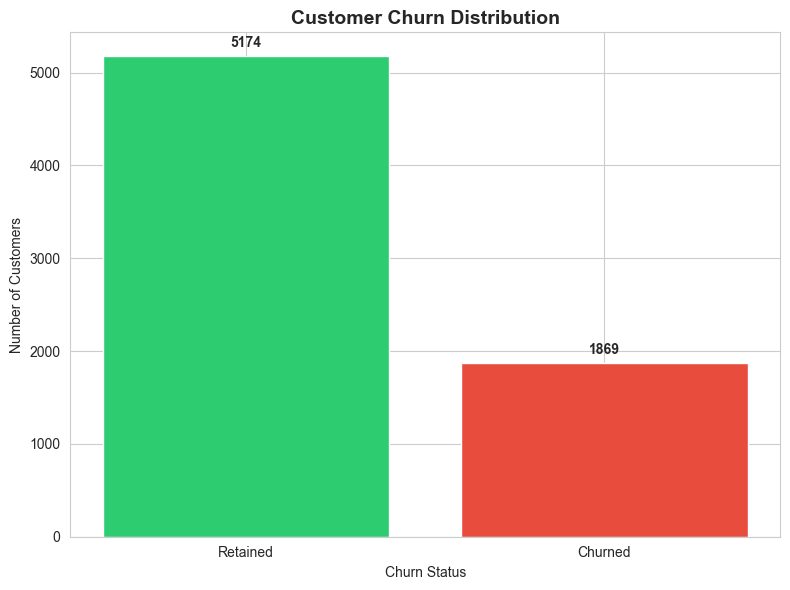

Churn rate: 26.54%


In [6]:
# Visualize churn distribution
plt.figure(figsize=(8, 6))
churn_counts = data['Churn'].value_counts()
plt.bar(churn_counts.index, churn_counts.values, color=['#2ecc71', '#e74c3c'])
plt.title('Customer Churn Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Churn Status')
plt.ylabel('Number of Customers')
plt.xticks([0, 1], ['Retained', 'Churned'])
for i, v in enumerate(churn_counts.values):
    plt.text(i, v + 100, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Churn rate: {(data['Churn'].value_counts()['Yes'] / len(data) * 100):.2f}%")

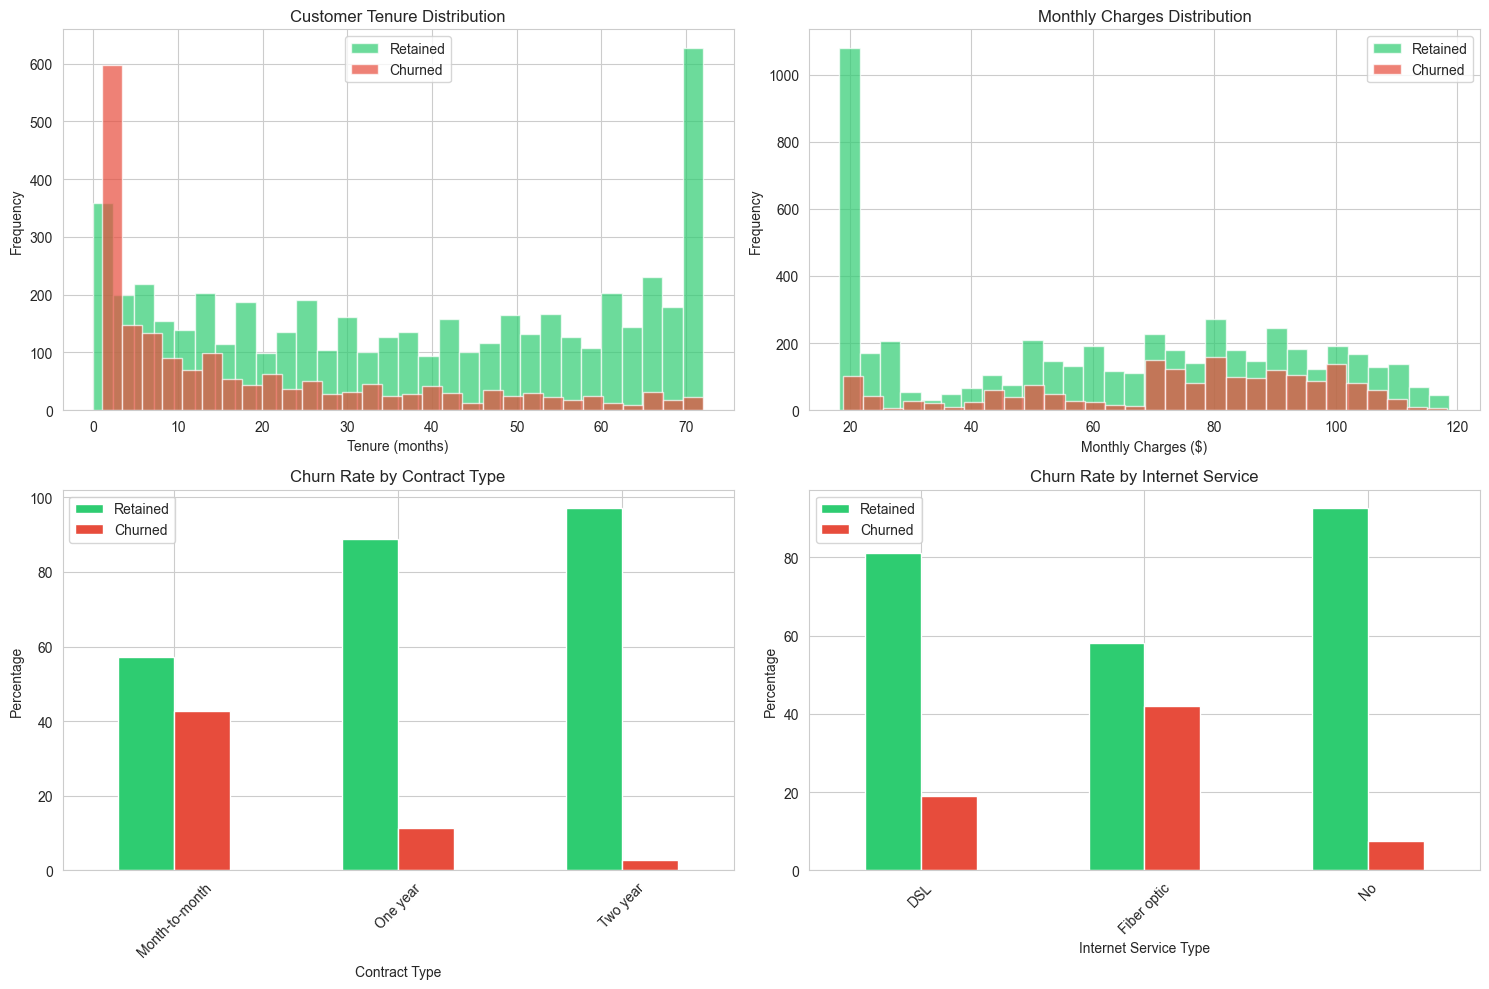

In [7]:
# Analyze key features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Tenure distribution
axes[0, 0].hist(data[data['Churn']=='No']['tenure'], bins=30, alpha=0.7, label='Retained', color='#2ecc71')
axes[0, 0].hist(data[data['Churn']=='Yes']['tenure'], bins=30, alpha=0.7, label='Churned', color='#e74c3c')
axes[0, 0].set_xlabel('Tenure (months)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Customer Tenure Distribution')
axes[0, 0].legend()

# Monthly charges
axes[0, 1].hist(data[data['Churn']=='No']['MonthlyCharges'], bins=30, alpha=0.7, label='Retained', color='#2ecc71')
axes[0, 1].hist(data[data['Churn']=='Yes']['MonthlyCharges'], bins=30, alpha=0.7, label='Churned', color='#e74c3c')
axes[0, 1].set_xlabel('Monthly Charges ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Monthly Charges Distribution')
axes[0, 1].legend()

# Contract type
contract_churn = pd.crosstab(data['Contract'], data['Churn'], normalize='index') * 100
contract_churn.plot(kind='bar', ax=axes[1, 0], color=['#2ecc71', '#e74c3c'])
axes[1, 0].set_xlabel('Contract Type')
axes[1, 0].set_ylabel('Percentage')
axes[1, 0].set_title('Churn Rate by Contract Type')
axes[1, 0].legend(['Retained', 'Churned'])
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)

# Internet service
internet_churn = pd.crosstab(data['InternetService'], data['Churn'], normalize='index') * 100
internet_churn.plot(kind='bar', ax=axes[1, 1], color=['#2ecc71', '#e74c3c'])
axes[1, 1].set_xlabel('Internet Service Type')
axes[1, 1].set_ylabel('Percentage')
axes[1, 1].set_title('Churn Rate by Internet Service')
axes[1, 1].legend(['Retained', 'Churned'])
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [8]:
# Create a copy for processing
df = data.copy()

# Remove customer ID as it's not predictive
df = df.drop('customerID', axis=1)

# Handle TotalCharges - convert to numeric and handle missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Convert target variable to binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Encode categorical variables
categorical_columns = df.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

print("Data preprocessing completed.")
print(f"Final dataset shape: {df.shape}")

Data preprocessing completed.
Final dataset shape: (7043, 20)


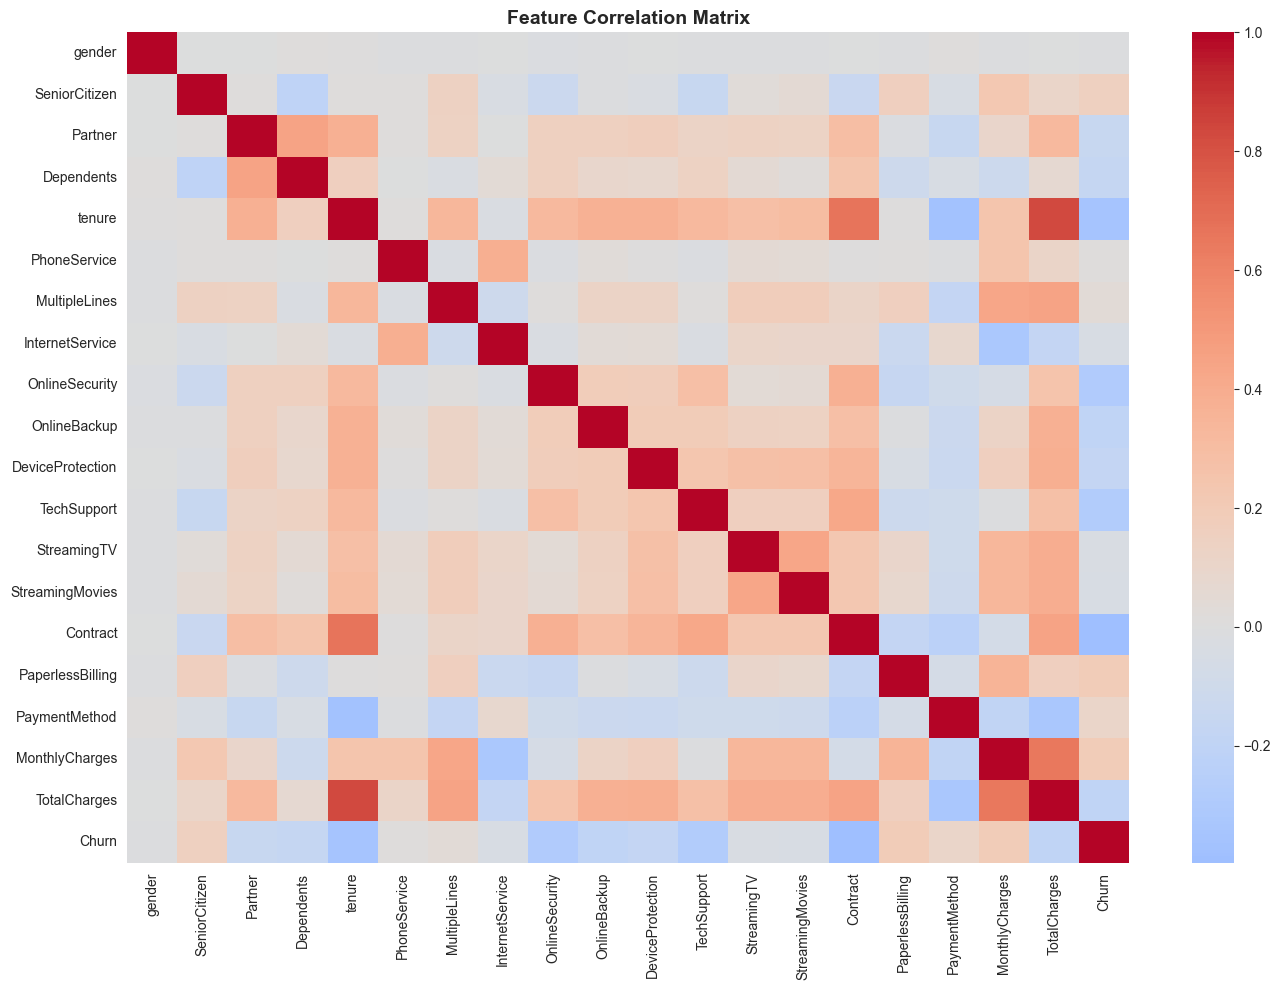


Top 10 features correlated with Churn:
MonthlyCharges      0.193356
PaperlessBilling    0.191825
SeniorCitizen       0.150889
PaymentMethod       0.107062
MultipleLines       0.038037
PhoneService        0.011942
gender             -0.008612
StreamingTV        -0.036581
StreamingMovies    -0.038492
InternetService    -0.047291
Name: Churn, dtype: float64


In [9]:
# Correlation analysis
plt.figure(figsize=(14, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Top correlations with Churn
churn_correlation = correlation_matrix['Churn'].sort_values(ascending=False)
print("\nTop 10 features correlated with Churn:")
print(churn_correlation[1:11])

In [10]:
# Split data into features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (4225, 19)
Validation set: (1409, 19)
Test set: (1409, 19)


## 4. Baseline Model - Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

# Create or set experiment
experiment_name = "Customer_Churn_Prediction"
mlflow.set_experiment(experiment_name)

print(f"Starting baseline model training...")
print("=" * 80)

with mlflow.start_run(run_name='baseline_logistic_regression'):
    # Initialize and train logistic regression model
    lr_model = LogisticRegression(
        random_state=42, max_iter=1000, solver='lbfgs')
    lr_model.fit(X_train_scaled, y_train)

    # Generate predictions
    y_pred = lr_model.predict(X_test_scaled)
    y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Log parameters to MLflow
    mlflow.log_param('model_type', 'LogisticRegression')
    mlflow.log_param('solver', 'lbfgs')
    mlflow.log_param('max_iter', 1000)

    # Log metrics to MLflow
    mlflow.log_metric('accuracy', accuracy)
    mlflow.log_metric('precision', precision)
    mlflow.log_metric('recall', recall)
    mlflow.log_metric('f1_score', f1)
    mlflow.log_metric('auc_roc', auc_score)

    # Log model artifact
    mlflow.sklearn.log_model(lr_model, "model")

    print("Baseline Model Performance Metrics:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print(f"  AUC-ROC:   {auc_score:.4f}")
    print("=" * 80)

2025/11/18 18:57:17 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/11/18 18:57:17 INFO mlflow.store.db.utils: Updating database tables
2025-11-18 18:57:17 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-11-18 18:57:17 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025-11-18 18:57:17 INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
2025-11-18 18:57:17 INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2025-11-18 18:57:17 INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2025-11-18 18:57:17 INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2025-11-18 18:57:17 INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2025-11-18 18:57:17 INFO  [alembic.runtime.mig

Starting baseline model training...


2025/11/18 18:57:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Baseline Model Performance Metrics:
  Accuracy:  0.7899
  Precision: 0.6189
  Recall:    0.5428
  F1 Score:  0.5783
  AUC-ROC:   0.8318


## 6. Advanced Model Development - LightGBM with Hyperparameter Optimization

In [17]:
import lightgbm as lgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Define hyperparameter search space
search_space = {
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'max_depth': hp.quniform('max_depth', 3, 12, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
    'min_child_samples': hp.quniform('min_child_samples', 10, 100, 5),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
}

print("Hyperparameter search space configured.")
print(f"Optimization will explore the following parameter ranges: {search_space}")

Hyperparameter search space configured.
Optimization will explore the following parameter ranges: {'num_leaves': <hyperopt.pyll.base.Apply object at 0x1659716d0>, 'max_depth': <hyperopt.pyll.base.Apply object at 0x165971b10>, 'learning_rate': <hyperopt.pyll.base.Apply object at 0x165971ed0>, 'n_estimators': <hyperopt.pyll.base.Apply object at 0x165972310>, 'min_child_samples': <hyperopt.pyll.base.Apply object at 0x165972890>, 'subsample': <hyperopt.pyll.base.Apply object at 0x165972d10>, 'colsample_bytree': <hyperopt.pyll.base.Apply object at 0x165973190>}


In [33]:
from mlflow.models import infer_signature


def objective(params):
    """
    Objective function for hyperparameter optimization.
    Creates top-level runs with proper model signatures and input examples.
    """
    # Convert continuous parameters to integers where required
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_samples'] = int(params['min_child_samples'])

    # Add fixed parameters
    params['random_state'] = 42
    params['objective'] = 'binary'
    params['metric'] = 'auc'
    params['verbose'] = -1
    params['force_col_wise'] = True

    # Create a top-level run for each trial
    with mlflow.start_run(run_name='lgbm_trial'):
        # Train model with early stopping
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train_scaled, y_train,
            eval_set=[(X_val_scaled, y_val)],
            callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=False)]
        )

        # Evaluate on validation set
        y_val_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
        y_val_pred = model.predict(X_val_scaled)

        # Calculate multiple metrics
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_precision = precision_score(y_val, y_val_pred)
        val_recall = recall_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred)
        val_auc = roc_auc_score(y_val, y_val_pred_proba)

        # Log all parameters and metrics
        mlflow.log_params(params)
        mlflow.log_metric('val_accuracy', val_accuracy)
        mlflow.log_metric('val_precision', val_precision)
        mlflow.log_metric('val_recall', val_recall)
        mlflow.log_metric('val_f1_score', val_f1)
        mlflow.log_metric('val_auc', val_auc)

        # Create input example and infer signature
        input_example = pd.DataFrame(X_train_scaled[:5], columns=X.columns)
        signature = infer_signature(X_train_scaled, y_val_pred_proba)

        # Log the model with signature and input example
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="model",
            signature=signature,
            input_example=input_example
        )

        # Add tags for easier filtering
        mlflow.set_tag("model_type", "LightGBM")
        mlflow.set_tag("stage", "hyperparameter_tuning")

    return {'loss': -val_auc, 'status': STATUS_OK}


print("Objective function defined and ready for optimization.")

Objective function defined and ready for optimization.


In [34]:
# Execute hyperparameter optimization
print("Initiating hyperparameter optimization...")
print("This process will evaluate 30 different parameter configurations.")
print("=" * 80)

trials = Trials()
best_params = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=30,
    trials=trials,
    verbose=1
)

print("\n" + "=" * 80)
print("Hyperparameter Optimization Completed")
print("=" * 80)
print("\nOptimal Parameters:")
for param, value in best_params.items():
    print(f"  {param:20s}: {value}")
print("=" * 80)

Initiating hyperparameter optimization...
This process will evaluate 30 different parameter configurations.
  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

2025/11/18 19:14:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



  3%|▎         | 1/30 [00:03<01:27,  3.01s/trial, best loss: -0.8572993360717145]

2025/11/18 19:14:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



  7%|▋         | 2/30 [00:05<01:11,  2.55s/trial, best loss: -0.8576002996719109]

2025/11/18 19:14:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 10%|█         | 3/30 [00:07<01:04,  2.37s/trial, best loss: -0.8576002996719109]

2025/11/18 19:14:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 13%|█▎        | 4/30 [00:09<01:01,  2.38s/trial, best loss: -0.8576002996719109]

2025/11/18 19:14:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 17%|█▋        | 5/30 [00:11<00:57,  2.30s/trial, best loss: -0.8576002996719109]

2025/11/18 19:14:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 20%|██        | 6/30 [00:13<00:53,  2.21s/trial, best loss: -0.8576002996719109]

2025/11/18 19:14:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 23%|██▎       | 7/30 [00:15<00:48,  2.12s/trial, best loss: -0.8576002996719109]

2025/11/18 19:14:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 27%|██▋       | 8/30 [00:18<00:52,  2.39s/trial, best loss: -0.8576002996719109]

2025/11/18 19:14:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 30%|███       | 9/30 [00:21<00:49,  2.34s/trial, best loss: -0.8576002996719109]

2025/11/18 19:14:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 33%|███▎      | 10/30 [00:23<00:47,  2.35s/trial, best loss: -0.8576002996719109]

2025/11/18 19:14:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 37%|███▋      | 11/30 [00:25<00:42,  2.25s/trial, best loss: -0.8576002996719109]

2025/11/18 19:14:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 40%|████      | 12/30 [00:27<00:39,  2.20s/trial, best loss: -0.8576002996719109]

2025/11/18 19:14:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 43%|████▎     | 13/30 [00:29<00:37,  2.23s/trial, best loss: -0.8576002996719109]

2025/11/18 19:15:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 47%|████▋     | 14/30 [00:31<00:34,  2.17s/trial, best loss: -0.8576894262316257]

2025/11/18 19:15:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 50%|█████     | 15/30 [00:34<00:33,  2.21s/trial, best loss: -0.8576894262316257]

2025/11/18 19:15:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 53%|█████▎    | 16/30 [00:36<00:30,  2.19s/trial, best loss: -0.8576894262316257]

2025/11/18 19:15:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 57%|█████▋    | 17/30 [00:38<00:27,  2.12s/trial, best loss: -0.8578741377974113]

2025/11/18 19:15:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 60%|██████    | 18/30 [00:40<00:25,  2.13s/trial, best loss: -0.8578741377974113]

2025/11/18 19:15:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 63%|██████▎   | 19/30 [00:42<00:23,  2.16s/trial, best loss: -0.8578741377974113]

2025/11/18 19:15:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 67%|██████▋   | 20/30 [00:44<00:22,  2.20s/trial, best loss: -0.8578741377974113]

2025/11/18 19:15:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 70%|███████   | 21/30 [00:47<00:19,  2.18s/trial, best loss: -0.8578741377974113]

2025/11/18 19:15:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 73%|███████▎  | 22/30 [00:49<00:17,  2.16s/trial, best loss: -0.8578741377974113]

2025/11/18 19:15:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 77%|███████▋  | 23/30 [00:51<00:15,  2.24s/trial, best loss: -0.8578741377974113]

2025/11/18 19:15:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 80%|████████  | 24/30 [00:53<00:13,  2.21s/trial, best loss: -0.8582203105221008]

2025/11/18 19:15:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 83%|████████▎ | 25/30 [00:55<00:10,  2.13s/trial, best loss: -0.8582203105221008]

2025/11/18 19:15:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 87%|████████▋ | 26/30 [00:57<00:08,  2.08s/trial, best loss: -0.8582203105221008]

2025/11/18 19:15:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 90%|█████████ | 27/30 [00:59<00:06,  2.04s/trial, best loss: -0.8582203105221008]

2025/11/18 19:15:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 93%|█████████▎| 28/30 [01:01<00:04,  2.00s/trial, best loss: -0.8582203105221008]

2025/11/18 19:15:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 97%|█████████▋| 29/30 [01:03<00:02,  2.04s/trial, best loss: -0.8582203105221008]

2025/11/18 19:15:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



100%|██████████| 30/30 [01:05<00:00,  2.19s/trial, best loss: -0.8582203105221008]

Hyperparameter Optimization Completed

Optimal Parameters:
  colsample_bytree    : 0.9630774405148073
  learning_rate       : 0.17825312065891527
  max_depth           : 7.0
  min_child_samples   : 85.0
  n_estimators        : 140.0
  num_leaves          : 76.0
  subsample           : 0.7920015804319211


In [37]:
from mlflow.models import infer_signature

# Create or set experiment
experiment_name = "Customer_Churn_Prediction"
mlflow.set_experiment(experiment_name)

# Train final model with optimal parameters
print("Training final model with optimized hyperparameters...")
print("=" * 80)

with mlflow.start_run(run_name='lightgbm_best_model_final'):
    # Convert parameters to appropriate types
    final_params = best_params.copy()
    final_params['num_leaves'] = int(final_params['num_leaves'])
    final_params['max_depth'] = int(final_params['max_depth'])
    final_params['n_estimators'] = int(final_params['n_estimators'])
    final_params['min_child_samples'] = int(final_params['min_child_samples'])
    final_params['random_state'] = 42
    final_params['objective'] = 'binary'
    final_params['metric'] = 'auc'
    final_params['verbose'] = -1
    final_params['force_col_wise'] = True

    # Train final model
    best_model = lgb.LGBMClassifier(**final_params)
    best_model.fit(
        X_train_scaled, y_train,
        eval_set=[(X_val_scaled, y_val)],
        callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=False)]
    )

    # Generate predictions on test set
    y_pred = best_model.predict(X_test_scaled)
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

    # Calculate comprehensive performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Log all parameters and metrics to MLflow
    mlflow.log_params(final_params)
    mlflow.log_metric('test_accuracy', accuracy)
    mlflow.log_metric('test_precision', precision)
    mlflow.log_metric('test_recall', recall)
    mlflow.log_metric('test_f1_score', f1)
    mlflow.log_metric('test_auc_roc', auc_score)

    # Add tags for identification
    mlflow.set_tag("model_type", "LightGBM")
    mlflow.set_tag("stage", "production_candidate")
    mlflow.set_tag("best_model", "true")

    # Create input example and infer signature
    input_example = pd.DataFrame(X_train_scaled[:5], columns=X.columns)
    signature = infer_signature(X_train_scaled, y_pred_proba)

    # Log model artifact with complete metadata
    mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="model",
        signature=signature,
        input_example=input_example,
        registered_model_name=None
    )

    # Save run ID for model registry
    best_run_id = mlflow.active_run().info.run_id

    print("Final Model Performance on Test Set:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print(f"  AUC-ROC:   {auc_score:.4f}")
    print("\nModel logged with signature and input example for production deployment.")
    print("=" * 80)

Training final model with optimized hyperparameters...


2025/11/18 19:20:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Final Model Performance on Test Set:
  Accuracy:  0.7942
  Precision: 0.6641
  Recall:    0.4545
  F1 Score:  0.5397
  AUC-ROC:   0.8324

Model logged with signature and input example for production deployment.


## 7. Model Evaluation and Visualization

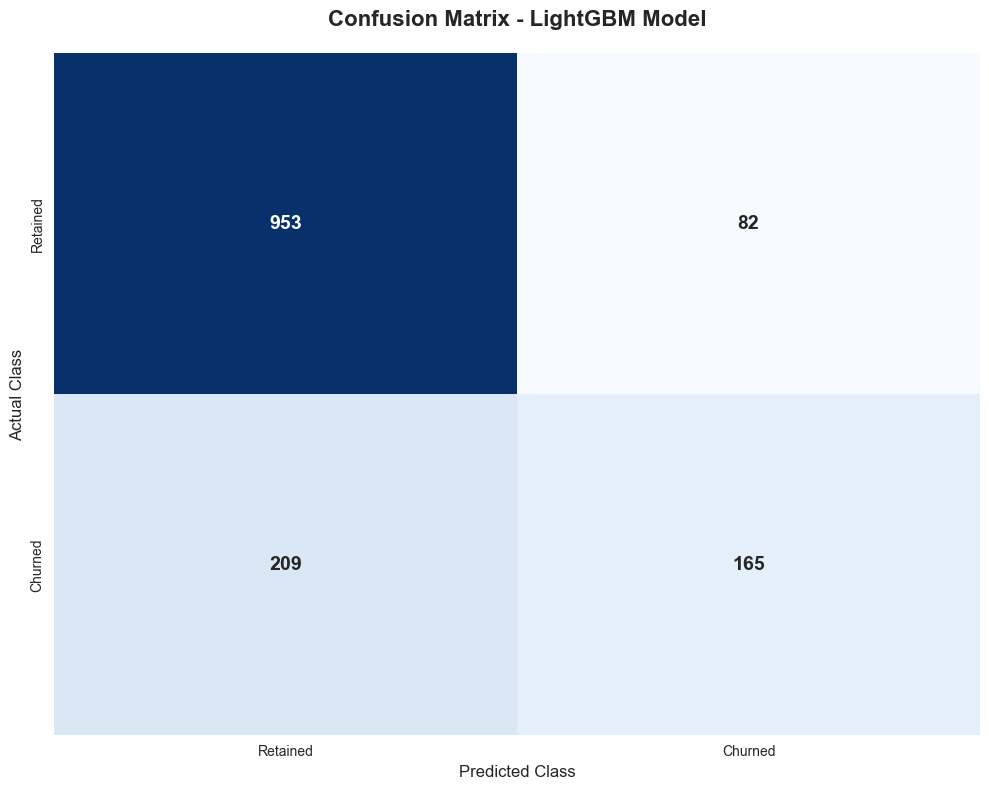


Classification Report:
              precision    recall  f1-score   support

    Retained       0.82      0.92      0.87      1035
     Churned       0.67      0.44      0.53       374

    accuracy                           0.79      1409
   macro avg       0.74      0.68      0.70      1409
weighted avg       0.78      0.79      0.78      1409



In [23]:
# Generate and visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'],
            annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Confusion Matrix - LightGBM Model', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Actual Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.tight_layout()
plt.savefig('assets/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Display detailed classification report
print("\nClassification Report:")
print("=" * 80)
print(classification_report(y_test, y_pred, target_names=['Retained', 'Churned']))
print("=" * 80)

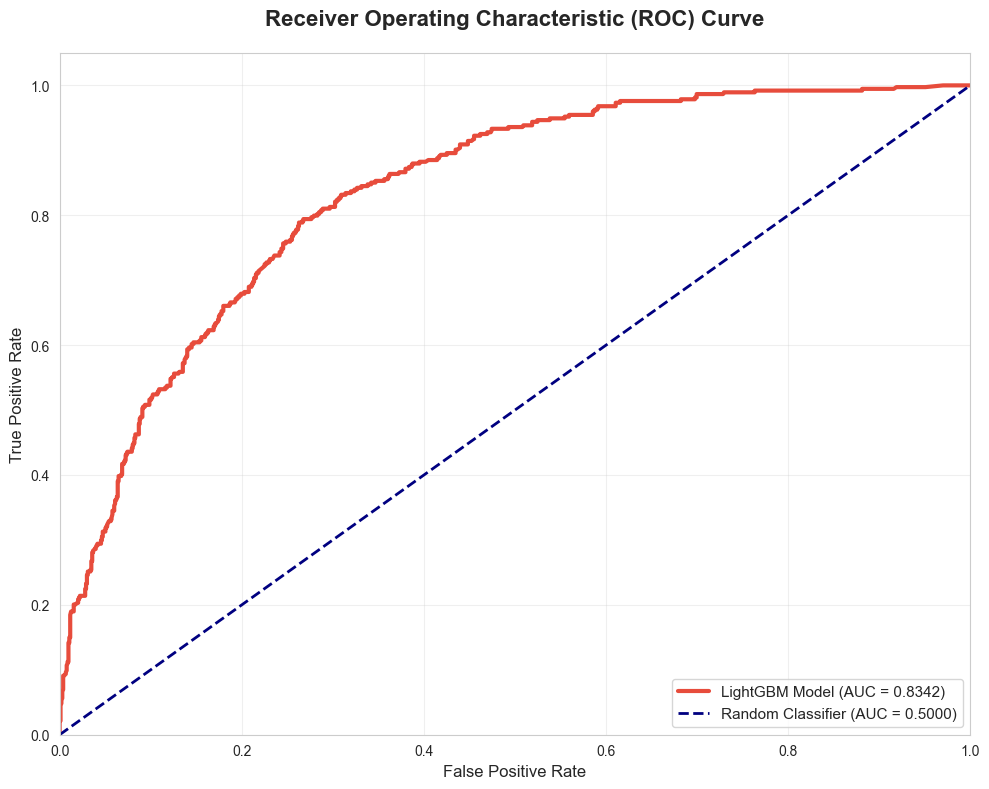

In [24]:
# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='#e74c3c', lw=3, label=f'LightGBM Model (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5000)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('assets/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

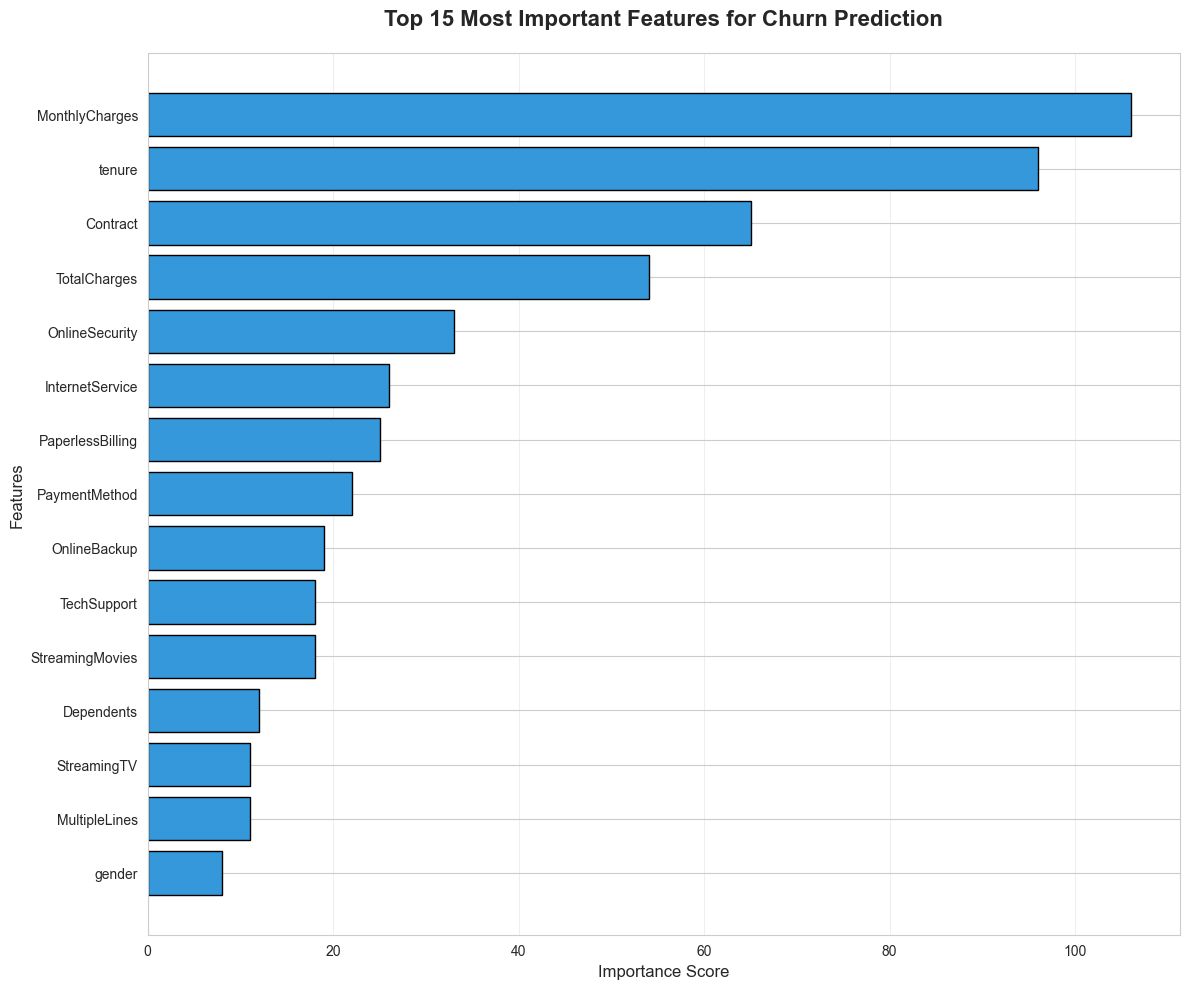


Top 10 Most Important Features:
MonthlyCharges                : 106.000000
tenure                        : 96.000000
Contract                      : 65.000000
TotalCharges                  : 54.000000
OnlineSecurity                : 33.000000
InternetService               : 26.000000
PaperlessBilling              : 25.000000
PaymentMethod                 : 22.000000
OnlineBackup                  : 19.000000
TechSupport                   : 18.000000


In [25]:
# Analyze and visualize feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
top_features = feature_importance.head(15)
plt.barh(top_features['feature'], top_features['importance'], color='#3498db', edgecolor='black')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 15 Most Important Features for Churn Prediction', fontsize=16, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('assets/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 10 Most Important Features:")
print("=" * 80)
for i, row in feature_importance.head(10).iterrows():
    print(f"{row['feature']:30s}: {row['importance']:.6f}")
print("=" * 80)

## 8. Model Registry and Version Management

In [38]:
import time

# Register model in MLflow Model Registry
model_name = "customer_churn_predictor"
model_uri = f"runs:/{best_run_id}/model"

print("Registering model in MLflow Model Registry...")
print("=" * 80)

try:
    model_version = mlflow.register_model(model_uri, model_name)
    print(f"Model successfully registered as '{model_name}'")
    print(f"Version: {model_version.version}")
    print(f"Run ID: {best_run_id}")
    time.sleep(5)

    # Transition model to production stage
    client = MlflowClient()
    client.transition_model_version_stage(
        name=model_name,
        version=model_version.version,
        stage="Production"
    )
    print(f"\nModel transitioned to Production stage.")

except Exception as e:
    print(f"Model registration encountered an issue: {e}")
    print("Note: Ensure MLflow tracking server supports model registry.")

print("=" * 80)

Registered model 'customer_churn_predictor' already exists. Creating a new version of this model...
2025/11/18 19:21:12 WARNING mlflow.tracking._model_registry.fluent: Run with id 22ca136929ad4cc9a020b4cbb63be9be has no artifacts at artifact path 'model', registering model based on models:/m-fe8653f5c32c4f84914e35d3a9758f38 instead


Registering model in MLflow Model Registry...
Model successfully registered as 'customer_churn_predictor'
Version: 3
Run ID: 22ca136929ad4cc9a020b4cbb63be9be


Created version '3' of model 'customer_churn_predictor'.



Model transitioned to Production stage.


## 11. Accessing MLflow Tracking UI

In [40]:
# Generate comprehensive experiment summary
client = MlflowClient()
experiment = mlflow.get_experiment_by_name("Customer_Churn_Prediction")
all_runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

print("="*80)
print("EXPERIMENT TRACKING SUMMARY")
print("="*80)
print(f"\nExperiment Name: {experiment.name}")
print(f"Experiment ID: {experiment.experiment_id}")
print(f"Total Runs: {len(all_runs)}")
print(f"\nMLflow Tracking URI: {mlflow.get_tracking_uri()}")
print("\nTo view detailed experiment tracking, run: mlflow ui --backend-store-uri sqlite:///mlflow.db --port 5000")
print("="*80)

EXPERIMENT TRACKING SUMMARY

Experiment Name: Customer_Churn_Prediction
Experiment ID: 1
Total Runs: 104

MLflow Tracking URI: sqlite:///mlflow.db

To view detailed experiment tracking, run: mlflow ui --backend-store-uri sqlite:///mlflow.db --port 5000


In [36]:
# Verify all models are logged in MLflow
experiment = mlflow.get_experiment_by_name("Customer_Churn_Prediction")
all_runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

print("=" * 80)
print("MLFLOW TRACKING VERIFICATION")
print("=" * 80)
print(f"\nTotal runs logged: {len(all_runs)}")
print(f"\nRun breakdown by model type:")

# Count runs by model type
if 'tags.model_type' in all_runs.columns:
    model_counts = all_runs['tags.model_type'].value_counts()
    for model_type, count in model_counts.items():
        print(f"  {model_type}: {count} runs")
else:
    print("  Note: Model type tags not found. Checking run names...")
    run_names = all_runs['tags.mlflow.runName'].value_counts()
    print("\nRuns by name:")
    for name, count in run_names.items():
        print(f"  {name}: {count}")

print("\n" + "=" * 80)
print("Most recent 5 runs:")
print("=" * 80)
recent_runs = all_runs.head(5)[['tags.mlflow.runName', 'start_time']]
print(recent_runs.to_string(index=False))
print("=" * 80)

MLFLOW TRACKING VERIFICATION

Total runs logged: 103

Run breakdown by model type:
  LightGBM: 67 runs

Most recent 5 runs:
      tags.mlflow.runName                       start_time
lightgbm_best_model_final 2025-11-19 00:15:43.337000+00:00
               lgbm_trial 2025-11-19 00:15:34.555000+00:00
               lgbm_trial 2025-11-19 00:15:32.439000+00:00
               lgbm_trial 2025-11-19 00:15:30.514000+00:00
               lgbm_trial 2025-11-19 00:15:28.570000+00:00
